In [25]:
import numpy as np
import torch
from sb3_contrib import TRPO
import pickle
import random
from tqdm.notebook import tqdm
from stable_baselines3.common.callbacks import BaseCallback
from PracticeProblemEnv import PracticeProblemEnv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# Callback, measure the performance of the model
class ProgressCallback(BaseCallback):
    def __init__(self, total_timesteps, verbose=1):
        super(ProgressCallback, self).__init__(verbose)
        self.total_timesteps = total_timesteps
        self.episode_rewards = []  # To store rewards of each episode
        self.rewards = []
        self.current_episode_reward = 0  # Reward accumulator for the current episode
        self.pbar = None

    def _on_training_start(self):
        self.pbar = tqdm(total=self.total_timesteps, desc="Training Progress")

    def _on_step(self):
        reward = self.locals["rewards"][0] # get the reward of the current step, assume there is only one env
        self.current_episode_reward += reward  # Accumulate rewards for the current episode
        self.rewards.append(reward)
        self.pbar.update(1)

        # Check if episode has ended
        done = self.locals["dones"][0]  # Check if the episode is done
        if done:
            self.episode_rewards.append(self.current_episode_reward)  # Save total reward for this episode
            self.current_episode_reward = 0  # Reset for the next episode
        
        # if self.n_calls % 1000 == 0:
            # if self.episode_rewards:  # Ensure there is at least one episode completed
                # ep_rew_mean = sum(self.episode_rewards) / len(self.episode_rewards)
                # tqdm.write(f"Step: {self.n_calls}, Episode mean reward: {ep_rew_mean}")
        return True
    def _on_training_end(self):
        self.pbar.close()


In [27]:
with open('result/akt_pid/assist2009_pid/args.pkl', 'rb') as f:
    params = pickle.load(f)
print(params)

Namespace(max_iter=300, train_set=1, seed=224, optim='adam', batch_size=24, lr=1e-05, maxgradnorm=-1, final_fc_dim=512, d_model=256, d_ff=1024, dropout=0.05, n_block=1, n_head=8, kq_same=1, l2=1e-05, q_embed_dim=50, qa_embed_dim=256, memory_size=50, init_std=0.1, hidden_dim=512, lamda_r=0.1, lamda_w1=0.1, lamda_w2=0.1, model='akt_pid', dataset='assist2009_pid', n_question=110, seqlen=200, data_dir='data/assist2009_pid', data_name='assist2009_pid', n_pid=16891, save='assist2009_pid', load='assist2009_pid')


In [29]:
env = PracticeProblemEnv(params,max_step=100, rew_func='mock', n_PperQ=10, units = [1], device=device)

# Define and train the TRPO model
model = TRPO('MlpPolicy', env, verbose=1)

# self-defined callback
total_timesteps = 1
callback = ProgressCallback(total_timesteps=total_timesteps)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [30]:
model.learn(total_timesteps=total_timesteps, callback=callback)

Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.1     |
|    ep_rew_mean     | 25.4     |
| time/              |          |
|    fps             | 48       |
|    iterations      | 1        |
|    time_elapsed    | 42       |
|    total_timesteps | 2048     |
---------------------------------


In [15]:
print(callback.episode_rewards)

[1.803852915763855, 0.9270824790000916, 0.9322019815444946, 1.8183193802833557, 1.810168445110321, 9.534172341227531, 58.6090894639492, 1.796882450580597, 6.924719035625458, 2.681238889694214, 0.9187982678413391, 75.53181760013103, 2.676046311855316, 1.8100755214691162, 0.9117347002029419, 8.811143219470978, 0.9171532988548279, 2.6881778836250305, 6.095680236816406, 42.89173011481762, 1.8049242496490479, 61.35483604669571, 0.9145845770835876, 75.90851500630379, 0.9186355471611023, 66.2934959679842, 10.406787291169167, 58.123849242925644, 0.9263333678245544, 45.97381213307381, 3.5895873308181763, 58.31058079004288, 46.909115850925446, 3.931904435157776, 60.9952200204134, 3.9606419801712036, 52.47991335391998, 34.394997984170914, 63.42200282216072, 0.9244753122329712, 0.925868034362793, 61.55039557814598, 64.230195581913, 65.6254022270441, 1.8099433183670044, 0.9008083343505859, 6.252740561962128, 1.8095272779464722, 0.9236915707588196, 0.9039317965507507, 0.9108116030693054, 0.911320805

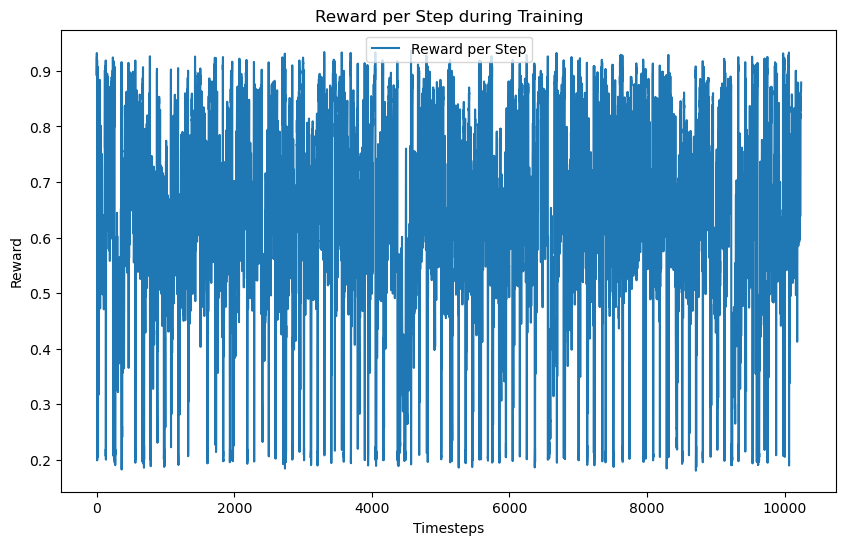

In [16]:
# 训练完成后，绘制奖励的可视化图
from matplotlib import pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(callback.rewards, label='Reward per Step')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.title('Reward per Step during Training')
plt.legend()
plt.show()

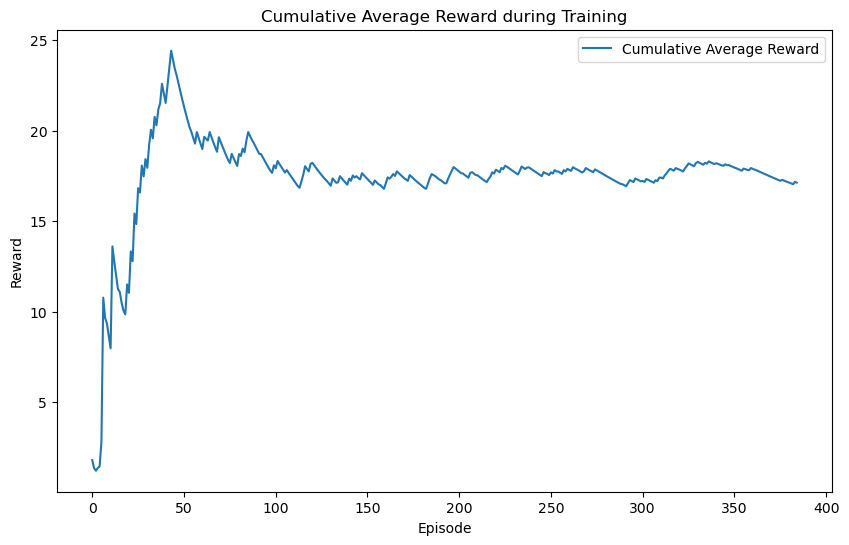

In [25]:
episode_rewards = callback.episode_rewards
cumulative_average = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_average, label='Cumulative Average Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Cumulative Average Reward during Training')
plt.legend()
plt.show()

In [26]:
print(f"episode_rewards: {callback.episode_rewards}")

episode_rewards: [1.803852915763855, 0.9270824790000916, 0.9322019815444946, 1.8183193802833557, 1.810168445110321, 9.534172341227531, 58.6090894639492, 1.796882450580597, 6.924719035625458, 2.681238889694214, 0.9187982678413391, 75.53181760013103, 2.676046311855316, 1.8100755214691162, 0.9117347002029419, 8.811143219470978, 0.9171532988548279, 2.6881778836250305, 6.095680236816406, 42.89173011481762, 1.8049242496490479, 61.35483604669571, 0.9145845770835876, 75.90851500630379, 0.9186355471611023, 66.2934959679842, 10.406787291169167, 58.123849242925644, 0.9263333678245544, 45.97381213307381, 3.5895873308181763, 58.31058079004288, 46.909115850925446, 3.931904435157776, 60.9952200204134, 3.9606419801712036, 52.47991335391998, 34.394997984170914, 63.42200282216072, 0.9244753122329712, 0.925868034362793, 61.55039557814598, 64.230195581913, 65.6254022270441, 1.8099433183670044, 0.9008083343505859, 6.252740561962128, 1.8095272779464722, 0.9236915707588196, 0.9039317965507507, 0.910811603069

In [31]:
# save the rewards
import pickle

data_to_save = {
    'episode_rewards': callback.episode_rewards,
    'rewards': callback.rewards
}

with open('saved_rewards.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

# save the env
with open('env.pkl', 'wb') as f:
    pickle.dump(env, f)

In [32]:
# load the env
with open('env.pkl', 'rb') as f:
    env = pickle.load(f)
# load the rewards
with open('saved_rewards.pkl', 'rb') as f:
    data = pickle.load(f)

In [33]:
# model.save("model_1000_100_mock1")
# model.load("model_1000_100_mock1")

## Evaluation Space

In [19]:
# Test the trained model
# model.load("model_1000_100_mock1")

obs, _ = env.reset()
env.switch_rew("correct")
obs_list = []
total_rewards = []
k=100
for _ in range(k):
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)
    total_rewards.append(rewards)
    obs_list.append(obs)
    if terminated or truncated:
        obs, _ = env.reset()

## Experimental Space

In [15]:
obs, rewards, terminated, truncated, info = env.step(np.array(75))

In [16]:
env.q_p_dict
sampled_concpets = []
sampled_problems = []
n_problems_per_type = 10
for question_type, question_ids in env.q_p_dict.items():
    num = min(n_problems_per_type, len(question_ids))
    sampled_problems += random.sample([*question_ids], num)
    sampled_concpets += ([question_type ] * num)

In [17]:
# sampled_problems = sampled_problems[:1]
# sampled_concpets = sampled_concpets[:1]

In [18]:
test_n_problem = len(sampled_problems)
q = torch.cat((torch.tensor(env.history['q'][-(env.params.seqlen-1):]).tile((test_n_problem,1)),(torch.tensor(sampled_concpets).unsqueeze(-1))),1)
target = torch.tensor(env.history['target'][-(env.params.seqlen-1):]+[0]).tile((test_n_problem,1))
pid = torch.cat((torch.tensor(env.history['pid'][-(env.params.seqlen-1):]).tile((test_n_problem,1)),(torch.tensor(sampled_problems).unsqueeze(-1))),1)
assert pid.shape == target.shape == pid.shape #(test_n_problem,3)
qa = q+target*env.params.n_question

In [19]:
padded_q = torch.zeros((test_n_problem, env.params.seqlen)) 
padded_qa = torch.zeros((test_n_problem, env.params.seqlen))
padded_target = torch.full((test_n_problem,env.params.seqlen),-1)
padded_pid = torch.zeros((test_n_problem, env.params.seqlen))

In [20]:
pred_index = q.shape[1]
padded_q[:, :pred_index]= q
padded_qa[:, :pred_index]= qa
padded_target[:, :pred_index]= target
padded_pid[:, :pred_index]= pid

In [21]:
q = padded_q.long().to(device)
qa = padded_qa.long().to(device)
target = padded_target.long().to(device)
pid = padded_pid.long().to(device)

In [22]:
with torch.no_grad():
    loss, pred, ct = env.kt_model(q,qa,target,pid)

In [23]:
nopadding_index = np.flatnonzero(padded_target.reshape((-1,)) >= -0.9).tolist()
pred_nopadding = pred[nopadding_index]

In [24]:
test_result = pred_nopadding[(pred_index-1)::pred_index]
assert test_result.shape == (test_n_problem,)
mean_performance = test_result.mean().item()
# return mean_performance